In [74]:
####################read dataset#########################
import os
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

image_folder = "data/img"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
#image_files

######################split dataset#######################
random.seed(0)
random.shuffle(image_files)
total_images = len(image_files)
train_ratio = 0.8

train_files = image_files[:int(total_images * train_ratio)]
test_files = image_files[int(total_images * train_ratio):]
#print(train_files)
#print(test_files)

In [75]:
#Create a vocabulary dictionary that maps all the unique color tokens from your train and test data as keys to a unique integer value.
item_attr_data = pd.read_csv("data/item_attr_data_cleaned.csv")
color_unique = item_attr_data['clothes_color'].unique()
print("number of colors:",len(color_unique))
color_vocab = sorted(set(color_unique))
color_vocabulary = {w:i for i, w in enumerate(color_vocab)}
#print(color_vocabulary)
for i,j in enumerate(item_attr_data['clothes_color']):
    color_value = color_vocabulary[j]
    item_attr_data.loc[i, "clothes_color"] = color_value

number of colors: 759


In [76]:
###################train dataset label##########################
train_ids=[]
for train_index in train_files:
    parts = train_index.split('/')
    train_ids.append(parts[2][:-4])
    
train_labels = pd.DataFrame(columns=item_attr_data.columns)
train_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in train_ids], axis=0, ignore_index=True)
train_labels = train_labels.drop(columns=['index','img_idx'])
train_color = train_labels.pop('clothes_color')

train_color_np = train_color.to_numpy(dtype=np.int32)
train_labels_np = train_labels.to_numpy(dtype=np.float32)
train_labels_np = (train_labels_np + 1) / 2

###################test dataset label##########################
test_ids=[]
for test_index in test_files:
    parts = test_index.split('/')
    test_ids.append(parts[2][:-4])
    
test_labels = pd.DataFrame(columns=item_attr_data.columns)
test_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in test_ids], axis=0, ignore_index=True)
test_labels = test_labels.drop(columns=['index','img_idx'])
test_color = test_labels.pop('clothes_color')

test_color_np = test_color.to_numpy(dtype=np.int32)
test_labels_np = test_labels.to_numpy(dtype=np.float32)
test_labels_np = (test_labels_np + 1) / 2

# print(train_labels_np[:5])
# print(train_color_np[:5])

In [77]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [78]:
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [79]:
train_color_ids_dataset = tf.data.Dataset.from_tensor_slices(train_color_np)
test_color_ids_dataset = tf.data.Dataset.from_tensor_slices(test_color_np)

train_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(train_labels_np)
test_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(test_labels_np)

train_dataset = tf.data.Dataset.zip((train_dataset, train_color_ids_dataset, train_binary_attributes_dataset))
test_dataset = tf.data.Dataset.zip((test_dataset, test_color_ids_dataset, test_binary_attributes_dataset))

train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [80]:
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 463), dtype=tf.float32, name=None))>


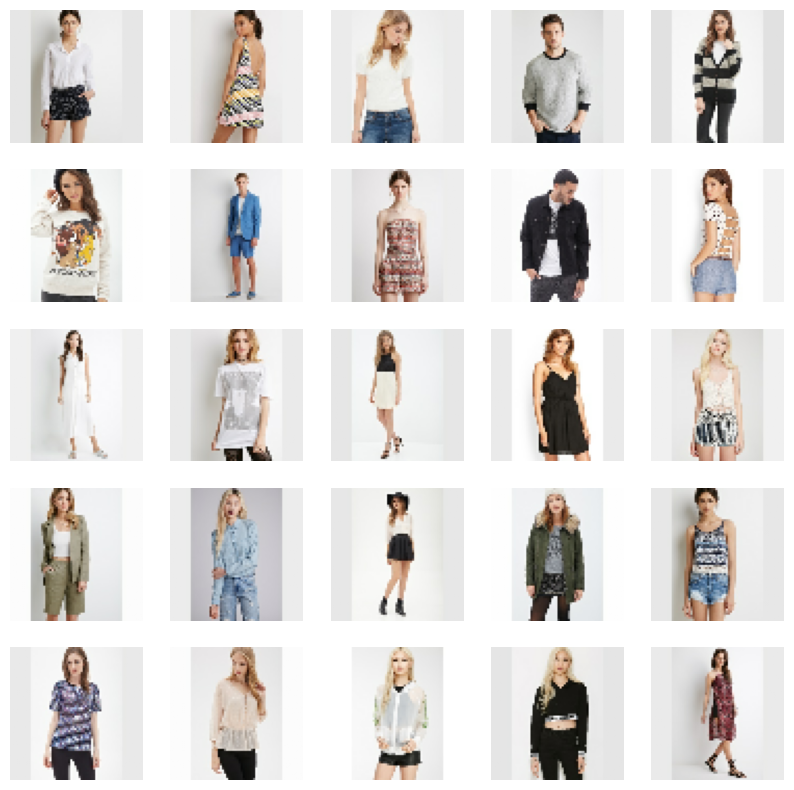

In [81]:
#################show the image####################
# Define a function to display a batch of images
def show_images(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()
    
# Get a batch of images from the train_dataset
for images, color_ids, binary_attributes in train_dataset.take(1):
    show_images(images)

In [184]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K


# Hyperparameters
embedding_dimension = 16
latent_dimension = 256
num_colors = 759
num_binary_attributes = 463
input_shape = (64, 64, 3)

# Cloth color embedding layer
color_embedding = layers.Embedding(num_colors, embedding_dimension, name="color_embedding")

# Encoder
# def create_encoder(input_shape, num_attributes):
#     inputs = Input(shape=input_shape, name="encoder_input")
#     attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
#     x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
#     x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     x = layers.Flatten()(x)
#     x = layers.Dense(latent_dimension, activation="relu")(x)
    
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     merged = layers.Concatenate()([x, attr_x])   
    
#     z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
#     z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
#     return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

def create_vgg16_encoder(input_shape, num_attributes):
    inputs = Input(shape=input_shape, name="encoder_input")
    attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
    # Use VGG16 as a feature extractor
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Set VGG16 layers to non-trainable
    for layer in vgg16.layers:
        layer.trainable = False
    
    # Apply VGG16 to the input images
    x = vgg16(inputs)
    
    # Flatten and reduce the dimensionality of the VGG16 features
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dimension, activation="relu")(x)
    
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
    
    merged = layers.Concatenate()([x, attr_x])
    
    z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
    return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")


def create_unet_decoder(latent_dimension, num_attributes):
    inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")

    x = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 64))(x)

    # Encoder part (contracting path)
    e1 = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    e2 = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(e1)

    # Decoder part (expanding path)
    d1 = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(e2)
    d1 = layers.Concatenate()([d1, e1])  # Skip connection
    d2 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(d1)
    d2 = layers.Concatenate()([d2, x])  # Skip connection

    outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(d2)

    return Model(inputs, outputs, name="decoder")

# # Decoder
# def create_decoder(latent_dimension, num_attributes):
#     inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")
    
#     x = layers.Dense(latent_dimension, activation="relu")(inputs)
#     x = layers.Dense(16 * 16 * 16, activation="relu")(x)
#     x = layers.Reshape((16, 16, 16))(x)
    
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(x)
    
#     return Model(inputs, outputs, name="decoder")

# CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder, color_embedding, num_binary_attributes, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.color_embedding = color_embedding
        self.num_binary_attributes = num_binary_attributes
    
    def call(self, inputs, training=False):
        images, color_ids, binary_attributes = inputs
        
        # Get color embeddings
        color_embeds = self.color_embedding(color_ids)
        
        # Concatenate color embeddings with binary attributes
        attribute_vector = layers.Concatenate(axis=-1)([color_embeds, binary_attributes])
        #attribute_vector = layers.Concatenate(axis=-1)([color_embeds])
        
        # Encode input images and attributes
        z_mean, z_log_var = self.encoder([images, attribute_vector])
        
        # Sample from the latent space
        batch_size = tf.shape(images)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        # Concatenate latent vector with the attribute vector
        z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])
        
        # Decode the conditioned latent vector
        reconstructed_images = self.decoder(z_cond)
        
        return reconstructed_images, z_mean, z_log_var

# Instantiate the encoder, decoder, and CVAE model
#encoder = create_encoder(input_shape, embedding_dimension + num_binary_attributes)
# decoder = create_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)
vgg16_encoder = create_vgg16_encoder(input_shape, embedding_dimension + num_binary_attributes)
unet_decoder = create_unet_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
cvae = CVAE(vgg16_encoder, unet_decoder, color_embedding, num_binary_attributes)
#cvae = CVAE(encoder, unet_decoder, color_embedding, num_binary_attributes)
# encoder = create_encoder(input_shape, embedding_dimension)
# decoder = create_decoder(latent_dimension, embedding_dimension)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)

# Loss function and optimizer
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Custom training step
@tf.function
def train_step(images, color_ids, binary_attributes):
    beta = 0.1
    with tf.GradientTape() as tape:
        reconstructed_images, z_mean, z_log_var = cvae([images, color_ids, binary_attributes], training=True)
        
        # Calculate reconstruction loss
        rec_loss = reconstruction_loss(layers.Flatten()(images), layers.Flatten()(reconstructed_images))
        rec_loss *= input_shape[0] * input_shape[1] * input_shape[2]
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # Combine losses
        total_loss = rec_loss + beta * kl_loss
    
    # Calculate gradients and update model weights
    gradients = tape.gradient(total_loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    
    return total_loss, rec_loss, kl_loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_images, batch_color_ids, batch_binary_attributes in train_dataset:
        total_loss, rec_loss, kl_loss = train_step(batch_images, batch_color_ids, batch_binary_attributes)
        print(f"Total loss: {total_loss:.4f}, Reconstruction loss: {rec_loss:.4f}, KL loss: {kl_loss:.4f}")

Epoch 1/10
Total loss: 1845.9502, Reconstruction loss: 1840.7131, KL loss: 52.3711
Total loss: 1848.0076, Reconstruction loss: 1842.2952, KL loss: 57.1244
Total loss: 1761.8199, Reconstruction loss: 1755.7606, KL loss: 60.5930
Total loss: 1692.5684, Reconstruction loss: 1685.9939, KL loss: 65.7449
Total loss: 1654.6969, Reconstruction loss: 1647.5891, KL loss: 71.0781
Total loss: 1559.7196, Reconstruction loss: 1551.9399, KL loss: 77.7970
Total loss: 1488.2939, Reconstruction loss: 1479.9089, KL loss: 83.8506
Total loss: 1381.8840, Reconstruction loss: 1372.7883, KL loss: 90.9570
Total loss: 1267.9139, Reconstruction loss: 1257.9940, KL loss: 99.1991
Total loss: 1183.0494, Reconstruction loss: 1172.1869, KL loss: 108.6253
Total loss: 1070.7330, Reconstruction loss: 1058.9377, KL loss: 117.9525
Total loss: 980.2696, Reconstruction loss: 967.3722, KL loss: 128.9739
Total loss: 870.5488, Reconstruction loss: 855.7234, KL loss: 148.2543
Total loss: 786.0766, Reconstruction loss: 769.7144, 

Total loss: 422.8598, Reconstruction loss: 412.9620, KL loss: 98.9777
Total loss: 411.4742, Reconstruction loss: 401.7236, KL loss: 97.5066
Total loss: 435.2227, Reconstruction loss: 425.5658, KL loss: 96.5696
Total loss: 441.5424, Reconstruction loss: 431.7523, KL loss: 97.9020
Total loss: 405.6563, Reconstruction loss: 396.1195, KL loss: 95.3684
Total loss: 412.1785, Reconstruction loss: 402.6396, KL loss: 95.3883
Total loss: 427.4780, Reconstruction loss: 417.9551, KL loss: 95.2290
Total loss: 405.3957, Reconstruction loss: 396.4666, KL loss: 89.2909
Total loss: 393.1224, Reconstruction loss: 383.6904, KL loss: 94.3205
Total loss: 418.2025, Reconstruction loss: 408.7832, KL loss: 94.1925
Total loss: 441.7124, Reconstruction loss: 432.6602, KL loss: 90.5223
Total loss: 413.1006, Reconstruction loss: 403.9181, KL loss: 91.8248
Total loss: 451.6418, Reconstruction loss: 442.8601, KL loss: 87.8172
Epoch 3/10
Total loss: 389.0905, Reconstruction loss: 380.1815, KL loss: 89.0908
Total los

Total loss: 334.9654, Reconstruction loss: 327.4706, KL loss: 74.9475
Total loss: 346.4734, Reconstruction loss: 339.0462, KL loss: 74.2716
Total loss: 358.5043, Reconstruction loss: 350.9013, KL loss: 76.0294
Total loss: 337.1419, Reconstruction loss: 329.6035, KL loss: 75.3849
Total loss: 357.0869, Reconstruction loss: 349.3719, KL loss: 77.1489
Total loss: 332.2039, Reconstruction loss: 324.4356, KL loss: 77.6830
Total loss: 372.7848, Reconstruction loss: 365.0076, KL loss: 77.7720
Total loss: 350.7805, Reconstruction loss: 343.2323, KL loss: 75.4825
Total loss: 358.2045, Reconstruction loss: 350.6706, KL loss: 75.3395
Total loss: 343.3726, Reconstruction loss: 335.7898, KL loss: 75.8282
Total loss: 330.7890, Reconstruction loss: 323.0129, KL loss: 77.7611
Total loss: 338.9012, Reconstruction loss: 331.1546, KL loss: 77.4652
Total loss: 339.3988, Reconstruction loss: 331.8130, KL loss: 75.8579
Total loss: 355.5647, Reconstruction loss: 347.7225, KL loss: 78.4222
Total loss: 356.7544

Total loss: 324.8748, Reconstruction loss: 314.1191, KL loss: 107.5567
Total loss: 303.1710, Reconstruction loss: 292.7790, KL loss: 103.9199
Total loss: 310.5067, Reconstruction loss: 299.9245, KL loss: 105.8219
Total loss: 294.9006, Reconstruction loss: 284.5098, KL loss: 103.9079
Total loss: 327.9474, Reconstruction loss: 317.3497, KL loss: 105.9763
Total loss: 300.0601, Reconstruction loss: 289.6333, KL loss: 104.2682
Total loss: 305.2089, Reconstruction loss: 294.5652, KL loss: 106.4375
Total loss: 305.9749, Reconstruction loss: 295.4295, KL loss: 105.4536
Total loss: 296.5719, Reconstruction loss: 285.9559, KL loss: 106.1599
Total loss: 296.7195, Reconstruction loss: 286.2892, KL loss: 104.3035
Total loss: 307.7231, Reconstruction loss: 296.9963, KL loss: 107.2684
Total loss: 292.0175, Reconstruction loss: 281.2727, KL loss: 107.4487
Total loss: 301.3479, Reconstruction loss: 290.7620, KL loss: 105.8589
Total loss: 298.6902, Reconstruction loss: 287.8613, KL loss: 108.2898
Total 

Total loss: 271.8921, Reconstruction loss: 259.1136, KL loss: 127.7848
Total loss: 286.2876, Reconstruction loss: 273.3249, KL loss: 129.6265
Total loss: 270.4392, Reconstruction loss: 257.8614, KL loss: 125.7782
Total loss: 293.4982, Reconstruction loss: 280.6557, KL loss: 128.4249
Total loss: 285.3134, Reconstruction loss: 272.2968, KL loss: 130.1660
Total loss: 276.1951, Reconstruction loss: 263.6484, KL loss: 125.4673
Total loss: 265.5662, Reconstruction loss: 252.8157, KL loss: 127.5047
Total loss: 267.2048, Reconstruction loss: 254.3683, KL loss: 128.3646
Total loss: 272.5240, Reconstruction loss: 259.5190, KL loss: 130.0493
Total loss: 281.2516, Reconstruction loss: 268.3978, KL loss: 128.5385
Total loss: 289.3234, Reconstruction loss: 276.4211, KL loss: 129.0229
Total loss: 263.3870, Reconstruction loss: 250.5513, KL loss: 128.3574
Total loss: 292.5509, Reconstruction loss: 279.3469, KL loss: 132.0404
Total loss: 277.0186, Reconstruction loss: 264.3160, KL loss: 127.0258
Total 

Total loss: 262.3036, Reconstruction loss: 247.6050, KL loss: 146.9860
Total loss: 250.1796, Reconstruction loss: 235.6304, KL loss: 145.4914
Total loss: 249.7750, Reconstruction loss: 235.3968, KL loss: 143.7821
Total loss: 251.0333, Reconstruction loss: 236.5378, KL loss: 144.9557
Total loss: 251.9812, Reconstruction loss: 237.3242, KL loss: 146.5694
Total loss: 260.1200, Reconstruction loss: 245.5761, KL loss: 145.4385
Total loss: 263.9151, Reconstruction loss: 249.2062, KL loss: 147.0887
Total loss: 266.9779, Reconstruction loss: 252.0622, KL loss: 149.1572
Total loss: 258.3625, Reconstruction loss: 243.4037, KL loss: 149.5877
Total loss: 259.9543, Reconstruction loss: 245.3942, KL loss: 145.6019
Total loss: 255.1485, Reconstruction loss: 240.4428, KL loss: 147.0574
Total loss: 242.5125, Reconstruction loss: 227.6880, KL loss: 148.2448
Total loss: 247.5503, Reconstruction loss: 232.7047, KL loss: 148.4567
Total loss: 263.5598, Reconstruction loss: 248.5534, KL loss: 150.0641
Total 

In [155]:
# Evaluate the trained model on the test dataset
test_loss = []
for batch_images, batch_color_ids, batch_binary_attributes in test_dataset:
    reconstructed_images, z_mean, z_log_var = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    rec_loss = reconstruction_loss(batch_images, reconstructed_images)
    rec_loss = tf.reduce_mean(rec_loss)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(kl_loss)
    total_loss = rec_loss + kl_loss
    test_loss.append(total_loss)

test_loss = tf.reduce_mean(test_loss)
print(f"Test loss: {test_loss:.4f}")

Test loss: 142.8786


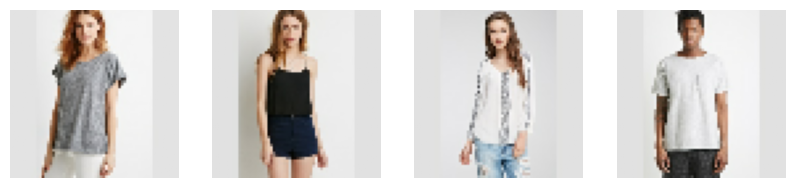

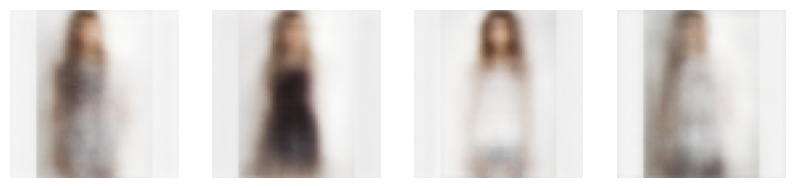

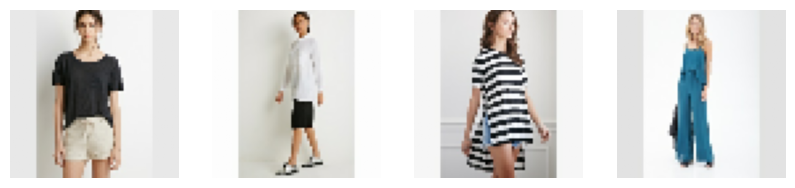

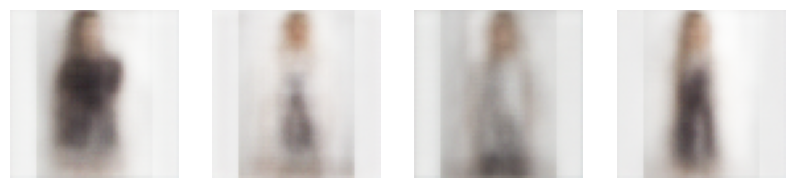

In [157]:
import matplotlib.pyplot as plt

def show(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(1,4,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

for batch_images, batch_color_ids, batch_binary_attributes in test_dataset.take(2):
    reconstructed_images, _, _ = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    show(batch_images)
    show(reconstructed_images)

In [158]:
def regenerate_image(image, new_color_id, new_binary_attributes):
    image = tf.expand_dims(image, axis=0)
    new_color_id = tf.expand_dims(new_color_id, axis=0)
    new_binary_attributes = tf.expand_dims(new_binary_attributes, axis=0)

    # Get color embeddings
    color_embeds = cvae.color_embedding(new_color_id)

    # Concatenate color embeddings with binary attributes
    attribute_vector = layers.Concatenate(axis=-1)([color_embeds, new_binary_attributes])

    # Encode input image and attributes
    z_mean, z_log_var = cvae.encoder([image, attribute_vector])

    # Sample from the latent space
    batch_size = tf.shape(image)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

    # Concatenate latent vector with the attribute vector
    z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])

    # Decode the conditioned latent vector
    regenerated_image = cvae.decoder(z_cond)

    return regenerated_image[0]

Cream-beige 


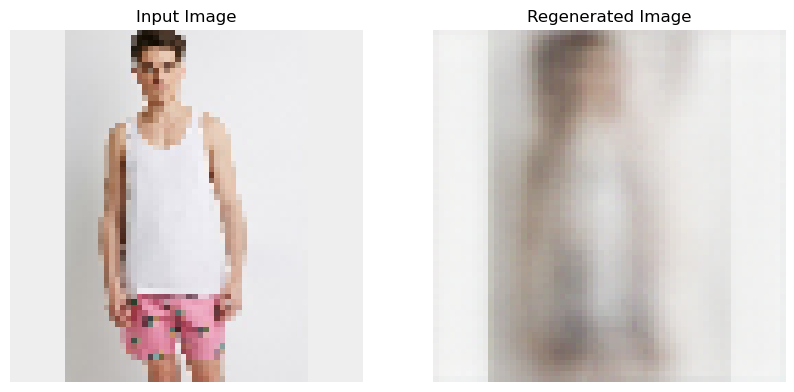

In [160]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

file = "data/img/id_00006150.jpg"
# Load the input image and preprocess it
input_image = cv2.imread(file)
input_image = cv2.resize(input_image, (64, 64))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = input_image / 255.0

# Define new color ID and binary attributes
new_color_id = 200  # Any integer value between 0 and 758 (num_colors - 1)
print(list(color_vocabulary.keys())[list(color_vocabulary.values()).index(new_color_id)])
#new_binary_attributes = np.random.randint(0, 2, size=(num_binary_attributes,)).astype(np.float32)
binary_attributes = item_attr_data[item_attr_data['img_idx']==file[9:-4]]
binary_attributes = binary_attributes.drop(columns=['index','img_idx','clothes_color'])

new_binary_attributes = binary_attributes.to_numpy(dtype=np.float32).flatten()
new_binary_attributes = (new_binary_attributes + 1) / 2


# Generate the new image
regenerated_image = regenerate_image(input_image, new_color_id, new_binary_attributes)

# Plot the input and regenerated images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(input_image)
ax1.set_title("Input Image")
ax1.axis("off")

ax2.imshow(regenerated_image)
ax2.set_title("Regenerated Image")
ax2.axis("off")

plt.show()